In [1]:
import os
import sys
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tools as tl
from coralModel import Reef, Organism, Ocean
import matplotlib.pyplot as plt
import matplotlib.colors as clt
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition


def create_reef(simulation):
    
    if grid_option == 0:
        
        np.random.seed(simulation)
        grid = [(i,j)
                for i in range(0, number_of_columns) 
                for j in range(0, number_of_rows)]
        np.random.shuffle(grid)
        coral_count = round(number_of_nodes*coral_percent)
        macro_count = round(number_of_nodes*macroalgae_percent)
        locations = {'coral': grid[0:coral_count],
                     'macro': grid[coral_count: coral_count + macro_count]}
    elif grid_option == 2:
        type_percent_dictionary = {0:coral_percent, 1:turf_percent, 2:macroalgae_percent}
        blob_percent = type_percent_dictionary[blob_value]
        not_blob = [a for a in [0,1,2] if a != blob_value]
        not_blob_percentages_adjusted = [round(type_percent_dictionary[n]/ 
                                               (1 - blob_percent), 2) for n in not_blob]
        blob_locations = tl.generate_blob(blob_percent, blob_value, 
                                          number_of_rows, number_of_columns, number_of_nodes)
    
    Moorea = Reef()
    count = 0
    for i in range(0, number_of_rows): 
        for j in range(0, number_of_columns):
            if grid_option == 0:  
                if (i,j) in locations['coral']:
                    U = 0
                elif (i,j) in locations['macro']:
                    U = 2
                else:
                    U = 1                   
            elif grid_option == 2:
                if (i,j) in blob_locations:
                    U = blob_value
                else:
                    U = np.random.choice(not_blob, p=not_blob_percentages_adjusted)
            elif grid_option == 3: ##for threshold plotting
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    return(Moorea)

def add_crash_time(df):
    
    dfcrash = df.copy()
    dfcrash = dfcrash[(dfcrash['coral_percent']!=0)]
    dfcrash['total_time_to_crash'] = 0
    
    for file in dfcrash['file'].unique():
        
        for Simulation in dfcrash[dfcrash['file']==file]['simulation'].unique():
            
            time = dfcrash[(dfcrash['file']==file) &
                           (dfcrash['simulation']==Simulation)].shape[0] * dfcrash['record_rate']
            dfcrash.loc[(dfcrash['file']==file)&(dfcrash['simulation']==Simulation),'total_time_to_crash'] = time

    dfcrash['time_to_crash'] = dfcrash['total_time_to_crash'] - dfcrash['timestep']
    dfcrash.loc[dfcrash['coral_success'] != -1, 'time_to_crash'] = -100

    return(dfcrash)

    
def prep_image(df, simulation, timestep):    
    image = df[(df['timestep']==timestep)&(df['simulation']==simulation)]['image']
    image = np.genfromtxt([image.values[0].replace('[', '').replace(']', '')])
    image = np.reshape(image, (25,25))
    return(image)


class HandlerSquare(HandlerPatch): ## for creating image legend

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p] 


In [2]:
path = './figures/paper/1_introduction_figure/'
extension = '.png'

#runs
top_directory = "./output/" #os.getcwd()
files, runs = tl.view_runs(top_directory)
runs

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
0,25,25,0,58,145,33,33,10,40,20,75,1100,10,10,0
1,25,25,0,57,145,33,33,10,40,20,75,1100,10,10,1
2,25,25,0,57,145,15,33,10,40,20,75,1100,10,10,2
3,25,25,0,57,145,15,33,10,40,20,75,1100,10,100,3
4,25,25,0,53,145,15,33,10,40,20,75,2100,10,10,4



## A. Neighborhood Topology: Threshold example

In [3]:
## Spatial Parameters

thresholds = [1.45, 11]
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
middle_node =  71 #27 #round(rows*rows/2)
simulation = 19

In [4]:
## Creating Grids

threshold_images = []
grid_option = 3 #specifically for plotting thresholds
reef = create_reef(simulation)

for threshold in thresholds:
    
    reef.generate_graph(threshold)
    neighbors = reef.graph[middle_node]
    
    for neighbor in neighbors:
        reef.nodes[neighbor].type = 1 
        
    reef.nodes[middle_node].type = 2
    
    reef_types = np.array([reef.nodes[i].type for i,val in enumerate(reef.nodes)], dtype=float)   
    threshold_images.append(np.reshape(reef_types, (number_of_rows, number_of_columns)))

In [5]:
## Plot Parameters

# Names
name = 'neighborhood_definition' 
titles = [r"Threshold ($\ell$) = "+str(thresholds[0]), 
          r"Threshold ($\ell$) = "+str(thresholds[1])]
legend_lables = ['Invisible', 'Neighborhood', 'Node of interest']

# Color Scheme
levels = [0, 1, 2]
colors = ['#f0f0f0', '#c596d6', '#522B29']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')


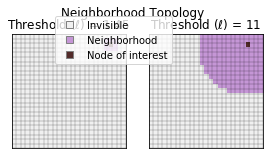

In [6]:
## Plot

def neighborhood_visualization():
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3))  
    fig.suptitle('Neighborhood Topology')
    
    for index, value in enumerate(threshold_images):
        ax[index].imshow(value, cmap=cmap, norm=norm)
        ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_frame_on(False)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].grid(color='black', linestyle='-', linewidth=.2, which='minor')
        ax[index].set_title(titles[index])
        ax[index].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
        ax[index].set_frame_on(True)
    patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_lables[i]) for i in levels]
    fig.legend(handles=patches,
               borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels},
               loc='center', bbox_to_anchor=(0.35,.55), shadow=False, ncol=1)
    fig.subplots_adjust(top=1.05)
    plt.savefig(path + name + extension, dpi=200)
    plt.show()

neighborhood_visualization()

## B. Zoomed-in example

In [7]:
## Example Run Parameters 

grazing = 58
subset = runs[(runs['neighborhood_threshold']==145)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
             (runs['initial_coral_percent']==33)]
subset

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
0,25,25,0,58,145,33,33,10,40,20,75,1100,10,10,0


In [8]:
## Load Example Run

df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df = tl.label_crash_statistics(df, coral_success=70)


df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')

In [9]:
## Plot Parameters

# Names
name = 'example_grid'
titles = ["Random", "Blob"]

# Color Scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

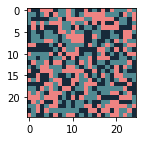

In [10]:
## Full Image Plot

simulation = 1

image = prep_image(df, simulation=simulation, timestep=0)
plt.figure(figsize=(2,2))
plt.imshow(image, cmap=cmap, norm=norm)
#plt.legend(handles=patches, bbox_to_anchor=(.99, .7), borderaxespad=0.,
#           handler_map={patches[i]:HandlerSquare() for i in levels})
plt.savefig(path + name + extension, dpi=400)

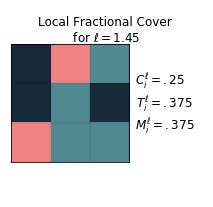

In [11]:
## Zoomed Image Plot

name = 'example_zoom'

fig, ax = plt.subplots(1,2, figsize=(3.5,3), gridspec_kw={'width_ratios': [2, 1]})

n=4

ax[0].imshow(image, cmap=cmap, norm=norm)
    
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_frame_on(False)
ax[0].grid(color='black', linestyle='-', linewidth=.1, which='minor')
ax[0].tick_params(which='minor', top=[], left=[], right=[], bottom=[])
ax[0].set_frame_on(True)
    
ax[0].axis((16.5+n, 19.5+n, 15.5, 12.5))
plt.suptitle("Local Fractional Cover" + "\n" + r" for $\ell = 1.45$")

ax[1].text(0.3, 0.5, 
           r"$C^{\ell}_{i} = .25$   "+"\n" + 
           "$T^{\ell}_{i} = .375$"+"\n"+ 
           "$M^{\ell}_{i} = .375 $", size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

    
fig.subplots_adjust(wspace=0.2, top=1.02)


plt.savefig(path + name + extension, dpi=400)


## C. Initial Profile: Random vs Blob

In [12]:
## Initial Profile Parameters

number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
coral_percent, macroalgae_percent = float(33)/100, float(33)/100
turf_percent = round(1 - coral_percent - macroalgae_percent, 2)

blob_value = 0
grid_option = 0
reef_random = create_reef(simulation)
grid_option = 2
reef_blob = create_reef(simulation)

In [13]:
## Create Initial Profiles

reef_random = np.reshape(np.array([reef_random.nodes[i].type for i,val in enumerate(reef_random.nodes)]),(number_of_rows,number_of_columns))
reef_blob = np.reshape(np.array([reef_blob.nodes[i].type for i,val in enumerate(reef_blob.nodes)]),(number_of_rows,number_of_columns))

In [14]:
## Plot Parameters

# Names
name = 'initial_profile'
titles = ["Random", "Blob"]
legend_keys = ['Coral ($\mathcal{C}$)', 'Turf ($\mathcal{T}$)', 'Macroalgae ($\mathcal{M}$)']

# Color Scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

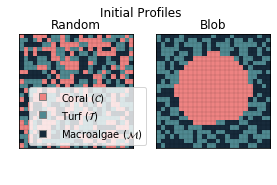

In [15]:
## Plot

def initial_grid_visualization():
    images = [reef_random, reef_blob]
    fig, ax = plt.subplots(1,2, figsize=(4.5, 3))  
    fig.suptitle('Initial Profiles')
    
    for index, value in enumerate(images):
        ax[index].imshow(value, cmap=cmap, norm=norm)
        ax[index].set_title(titles[index])
        #ax[index].set_frame_on(False)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_frame_on(False)
        ax[index].grid(color='black', linestyle='-', linewidth=.1, which='minor')
        ax[index].set_title(titles[index])
        ax[index].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
        ax[index].set_frame_on(True)
    fig.subplots_adjust(top=1.05)
    
    patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_keys[i]) for i in levels]
    fig.legend(handles=patches,
               borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels},
               loc='center', bbox_to_anchor=(0.27,.32), shadow=False, ncol=1)
    
    plt.savefig(path + name + extension, dpi=200, bbox_inches = 'tight')
    plt.show()
initial_grid_visualization()

## D. Example Temporal Evolution

In [16]:
#Pull fractional cover

df['C'] = round(df.coral_percent/100,2)
df['T'] = round(df.turf_percent/100,2)
df['M'] = round(df.macroalgae_percent/100,2)

dfplot = df.copy()

df_to_melt = dfplot[['C','timestep', 'time', 'simulation', 'M', 'T']]
df_melted = pd.melt(df_to_melt, id_vars=['timestep','time','simulation'], value_vars=['C', 'T','M'])
df_melted.head()

## Isolate Statistical Descriptors of Example Run

maxC = df[['C','time']].groupby('time').max()['C']
minC = df[['C','time']].groupby('time').min()['C']
meanC = df[['C','time']].groupby('time').mean()['C']

maxT = df[['T','time']].groupby('time').max()['T']
minT = df[['T','time']].groupby('time').min()['T']
meanT = df[['T','time']].groupby('time').mean()['T']

maxM = df[['M','time']].groupby('time').max()['M']
minM = df[['M','time']].groupby('time').min()['M']
meanM = df[['M','time']].groupby('time').mean()['M']

C = df[df['simulation']==simulation]['C']
T = df[df['simulation']==simulation]['T']
M = df[df['simulation']==simulation]['M']

time = df['time'].unique()

In [17]:
## Plot parameters

# Color scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

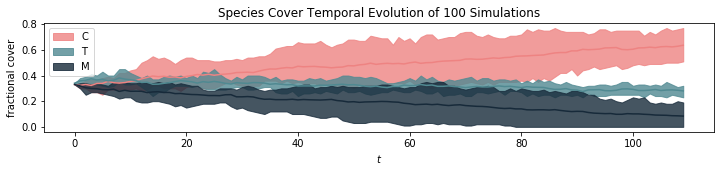

In [18]:
## Plot Min/Max/Mean Timeseries
name ='min_max_mean_timeseries'
plt.figure(figsize=(12,2))

plt.fill_between(time, minC, maxC, alpha=.8, color='#EE8382', label='C')
plt.fill_between(time, minT, maxT , alpha=.8, color='#508991', label='T')
plt.fill_between(time, minM, maxM, alpha=.8, color='#172A3A', label='M')

plt.plot(time, meanC, 'k-', color='#EE8382')
plt.plot(time, meanT, 'k-', color='#508991')
plt.plot(time, meanM, 'k-', color='#172A3A')

plt.title('Species Cover Temporal Evolution of 100 Simulations')
plt.legend(loc='upper left')
plt.ylabel("fractional cover")
plt.xlabel(r"$t$")

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

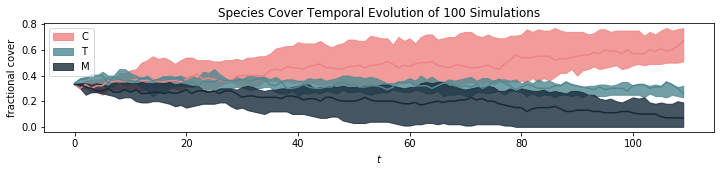

In [19]:
## Plot Min/Max/Example Timeseries

name ='min_max_example_timeseries'
plt.figure(figsize=(12,2))

plt.fill_between(time, minC, maxC, alpha=.8, color='#EE8382', label='C')
plt.fill_between(time, minT, maxT , alpha=.8, color='#508991', label='T')
plt.fill_between(time, minM, maxM, alpha=.8, color='#172A3A', label='M')

plt.plot(time, C, 'k-', color='#EE8382')
plt.plot(time, T, 'k-', color='#508991')
plt.plot(time, M, 'k-', color='#172A3A')

plt.title('Species Cover Temporal Evolution of 100 Simulations')
plt.legend(loc='upper left')
plt.ylabel("fractional cover")
plt.xlabel(r"$t$")

plt.savefig(path + name + extension, bbox_inches = "tight")

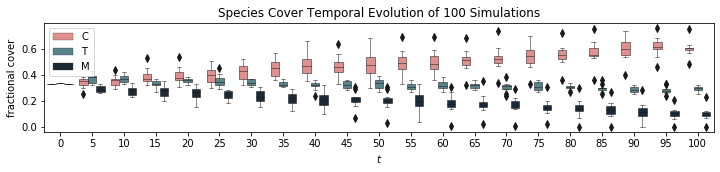

In [20]:
name ='boxplot_temporal_evolution'

timesteps = [0, 50, 100, 150, 200, 250, 300, 350, 400, 
             450, 500, 550, 600, 650, 700, 750, 800, 
             850, 900, 950, 1000]

plt.figure(figsize=(12,2))
fig = sns.boxplot(x="time", y="value", hue="variable", 
            data=df_melted[df_melted['timestep'].isin(timesteps)], palette=type_palette,
            linewidth=.5)
plt.title('Species Cover Temporal Evolution of 100 Simulations')
plt.legend(loc='upper left')
plt.ylabel("fractional cover")
plt.xlabel(r"$t$")
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

## E. Spatial Evolution

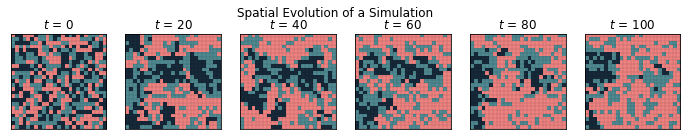

In [21]:
name = 'spatial_evolution_images'

simulation = 1
#timesteps = [0, 300, 600, 900]

timesteps = [0, 200, 400, 600, 800, 1000]



fig, ax = plt.subplots(1, len(timesteps), figsize=(12,2)) 

for index in range(0, len(timesteps)):    
    image = prep_image(df,simulation,timesteps[index])    
    ax[index].imshow(image, cmap=cmap, norm=norm)
    ax[index].set_title(r'$t$ = ' + str(int(timesteps[index]*.1)))


    ax[index].set_yticks([])
    ax[index].set_xticks([])
    ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
    ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
    ax[index].set_frame_on(False)
    ax[index].grid(color='black', linestyle='-', linewidth=.1, which='minor')
    ax[index].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
    ax[index].set_frame_on(True)
    
fig.subplots_adjust(wspace=0.2, top=.79)
fig.suptitle('Spatial Evolution of a Simulation')
plt.savefig(path + name + extension, dpi=400, bbox_inches = 'tight')


_____
_____
## Unused Code Below
____

Text(0.5, 0.98, 'test')

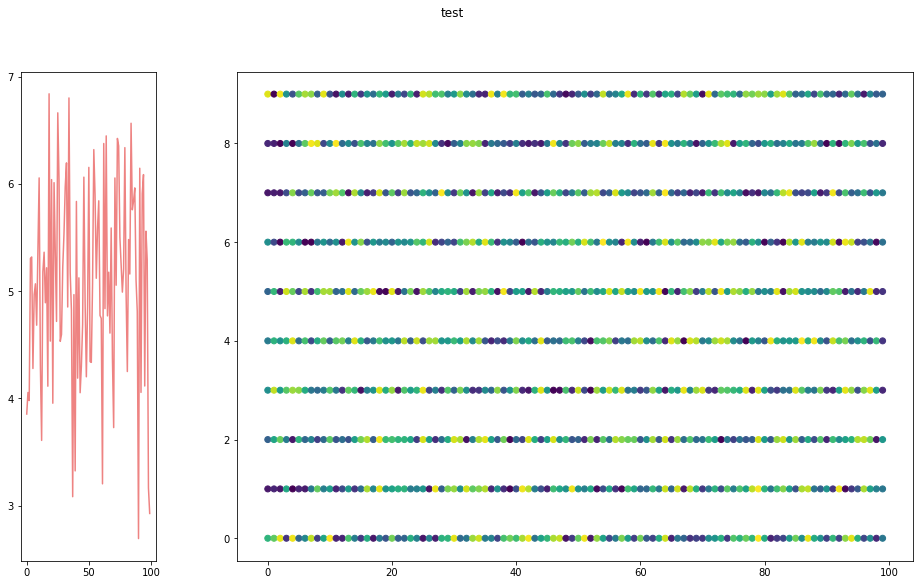

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#generate random data
x,y=range(100), range(10)
z=np.random.random((len(x),len(y)))
Y=Y=[z[i].sum() for i in range(len(x))]
z=pd.DataFrame(z).unstack().reset_index()



#Plot data
fig, axs = plt.subplots(1,2,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})
axs[0].plot(Y)
axs[1].scatter(z['level_1'], z['level_0'],c=z[0])

plt.suptitle("test")



In [ ]:
thresholds = [1.45, 5, 11, 15]
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
middle_node =  71 #27 #round(rows*rows/2)
simulation = 19
threshold_images=[]

grid_option = 3 #specifically for plotting thresholds
reef = create_reef(simulation)

for threshold in thresholds:
    
    reef.generate_graph(threshold)
    neighbors = reef.graph[middle_node]
    
    for neighbor in neighbors:
        reef.nodes[neighbor].type = 1 
        
    reef.nodes[middle_node].type = 2
    
    reef_types = np.array([reef.nodes[i].type for i,val in enumerate(reef.nodes)], dtype=float)   
    threshold_images.append(np.reshape(reef_types, (number_of_rows, number_of_columns)))


In [ ]:
levels = [0, 1, 2, 3, 4]
#colors = ['#495490','#88527F', '#B1DDF1','#688B58','#FFFFFF']
colors = ['#b3cde0','#6497b1', '#005b96','#011f4b','#FFFFFF']


#colors = ['#495490', '#f0f0f0', '#c596d6', '#522B29','#499075']
legend_lables = ['$l=36$','$l=11$', '$l=5$', '$l=1.45$', 'node of interest']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))

name = 'overlapped'
ax.imshow(threshold_images[0]+threshold_images[1]+ threshold_images[2], cmap, norm)
ax.set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_xticks([])
ax.grid(color='grey', linestyle='-', linewidth=.3, which='minor')
ax.tick_params(which='minor', top=[], left=[], right=[], bottom=[])
ax.set_frame_on(True)

plt.title('Various Neighborhood \n Topologies')

patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_lables[i]) for i in levels]
legend = ax.legend(handles=patches,
                   borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels}, 
                   loc='center', bbox_to_anchor=(-0.10, 0.5), shadow=False, ncol=1)
fig.savefig(path + name + extension,bbox_inches = 'tight')

plt.show()

In [ ]:
#sns.set_style("ticks")

# Color Palettes
levels = [0, 1, 2]
colors = ['#EE8382', '#4D7C84', '#172A3A']
palette_type = sns.set_palette(sns.color_palette(colors))
cmap_type, norm_type = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

colors = ['#f0f0f0', '#c596d6', '#522B29']
cmap_threshold, norm_threshold = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')